# CNN + MaxPool

Use GlobalMaxPooling like CNN_261.

Use GMM instead of -1 RCI threshold.

Use all transcripts instead of canonical.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-21 17:03:27.454492


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.all_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.all_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.all_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = GlobalMaxPooling1D()
    #pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #cnn3_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #cnn4_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    #drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    #cnn.add(cnn2_layer)
    cnn.add(pool1_layer)
    #cnn.add(cnn3_layer)
    #cnn.add(cnn4_layer)
    #cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    #cnn.add(drop_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-21 17:03:56.712628
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4990, 64)          2112      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
___________________________

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-21 17:03:57.011563
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.all_lncRNA_transcripts.csv
Loaded 19789 sequences.
2023-03-21 17:04:27.163009

Training # 1 1
2023-03-21 17:04:27.164173
2023-03-21 17:04:27.164227
Discriminator is GMM
Means [-1.6758399311172867, 0.1319803166777027]
Variances [2.46099075 1.41731718]
Priors [0.49004469 0.50995531]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 8950:7109 55.73%
Computed class weights: {0: 1.1294837529891686, 1: 0.8971508379888268}
Valid 1:0 2347:1383 62.92%
FIT
2023-03-21 17:04:43.068987


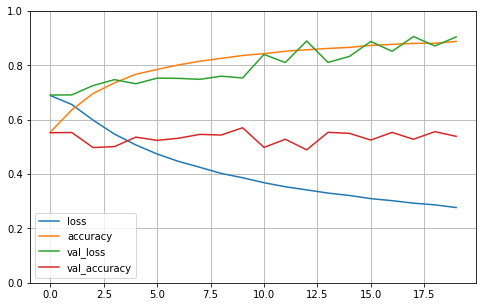


2023-03-21 17:06:38.627784

Testing # 1 1
2023-03-21 17:06:38.627891
2023-03-21 17:06:38.627930
PREDICT
2023-03-21 17:06:39.581445
Test 1:0 2347:1383 62.92%
Predict 1:0 2035:1695 54.56%
Test sizes (3730, 4997) (3730,)
Range of scores: 0.0014075207 to 0.9969831
Score threshold 0.5
Confusion matrix
 [[ 679  704]
 [1016 1331]]
Normalized matrix
 [[0.18203753 0.18873995]
 [0.27238606 0.35683646]]


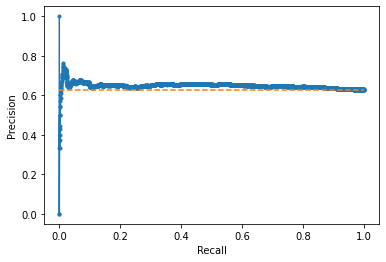

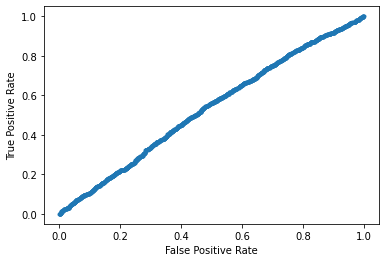

Accuracy: 53.89% Precision: 65.41% Recall: 56.71%
F1: 60.75% MCC: 0.0563
AUPRC: 64.91% AUROC: 53.34%
 accuracy [53.88739946380697]
 precision [65.4054054054054]
 recall [56.71069450362164]
 F1 [60.748516659059796]
 MCC [0.056330304778744116]
 AUPRC [64.90997209174381]
 AUROC [53.335961263143886]
2023-03-21 17:06:41.185979

Training # 1 2
2023-03-21 17:06:41.186833
2023-03-21 17:06:41.186881
Discriminator is GMM
Means [-1.826020454979901, -0.03397415782309363]
Variances [2.76217046 1.45934423]
Priors [0.41427002 0.58572998]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10877:4923 68.84%
Computed class weights: {0: 1.6047125736339631, 1: 0.7263032086053139}
Valid 1:0 2739:1250 68.66%
FIT
2023-03-21 17:06:56.916862


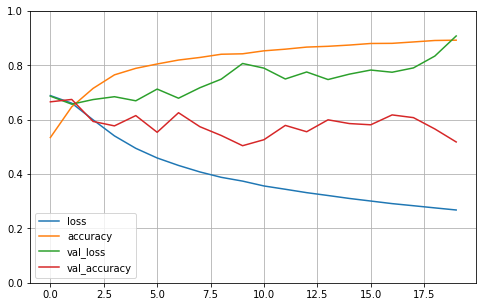


2023-03-21 17:08:46.263844

Testing # 1 2
2023-03-21 17:08:46.264170
2023-03-21 17:08:46.264213
PREDICT
2023-03-21 17:08:47.257210
Test 1:0 2739:1250 68.66%
Predict 1:0 2057:1932 51.57%
Test sizes (3989, 4997) (3989,)
Range of scores: 0.0010105838 to 0.9987054
Score threshold 0.5
Confusion matrix
 [[ 630  620]
 [1302 1437]]
Normalized matrix
 [[0.15793432 0.15542743]
 [0.32639759 0.36024066]]


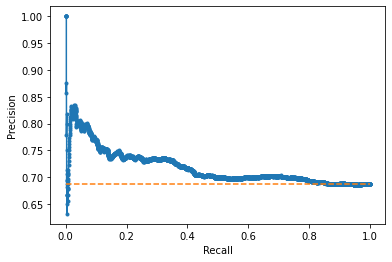

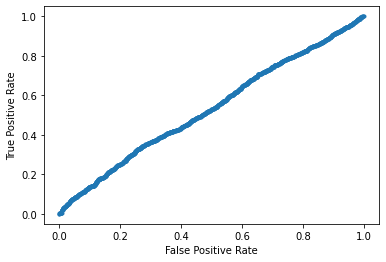

Accuracy: 51.82% Precision: 69.86% Recall: 52.46%
F1: 59.92% MCC: 0.0266
AUPRC: 71.80% AUROC: 53.34%
 accuracy [51.81749811982953]
 precision [69.85901798736023]
 recall [52.46440306681271]
 F1 [59.924937447873226]
 MCC [0.026586700654833335]
 AUPRC [71.80393609054492]
 AUROC [53.34376049653158]
2023-03-21 17:08:49.461028

Training # 1 3
2023-03-21 17:08:49.463339
2023-03-21 17:08:49.463397
Discriminator is GMM
Means [0.053831580061722305, -1.8006680083401607]
Variances [1.42148915 2.5060403 ]
Priors [0.56805585 0.43194415]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10604:5567 65.57%
Computed class weights: {0: 1.4523980599964075, 1: 0.7624952847981894}
Valid 1:0 2302:1316 63.63%
FIT
2023-03-21 17:09:03.979559


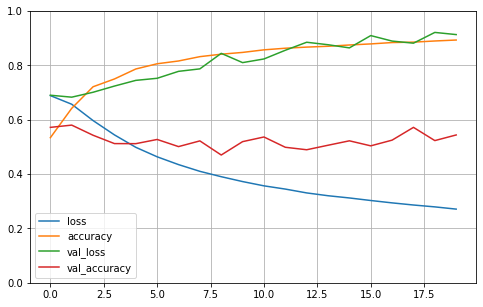


2023-03-21 17:11:27.801515

Testing # 1 3
2023-03-21 17:11:27.801948
2023-03-21 17:11:27.801985
PREDICT
2023-03-21 17:11:28.703966
Test 1:0 2302:1316 63.63%
Predict 1:0 2210:1408 61.08%
Test sizes (3618, 4997) (3618,)
Range of scores: 0.0052508526 to 0.99958307
Score threshold 0.5
Confusion matrix
 [[ 537  779]
 [ 871 1431]]
Normalized matrix
 [[0.14842454 0.21531233]
 [0.24074074 0.39552239]]


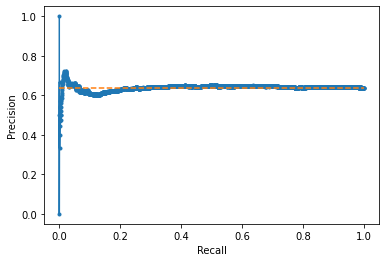

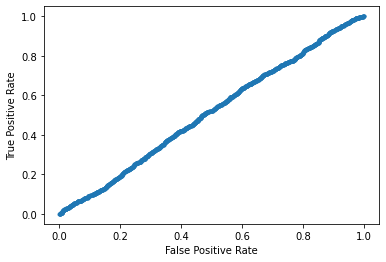

Accuracy: 54.39% Precision: 64.75% Recall: 62.16%
F1: 63.43% MCC: 0.0293
AUPRC: 63.93% AUROC: 51.25%
 accuracy [54.39469320066335]
 precision [64.75113122171946]
 recall [62.163336229365775]
 F1 [63.430851063829785]
 MCC [0.029293088060282163]
 AUPRC [63.928465725913554]
 AUROC [51.24927709220739]
2023-03-21 17:11:30.186853

Training # 1 4
2023-03-21 17:11:30.187050
2023-03-21 17:11:30.187104
Discriminator is GMM
Means [-1.8741662760461324, 0.006516733898399464]
Variances [2.56395909 1.370483  ]
Priors [0.42766015 0.57233985]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10387:5526 65.27%
Computed class weights: {0: 1.4398298950416215, 1: 0.7660055839029556}
Valid 1:0 2737:1139 70.61%
FIT
2023-03-21 17:11:42.400059


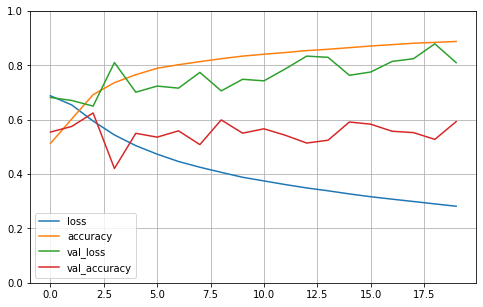


2023-03-21 17:14:06.493263

Testing # 1 4
2023-03-21 17:14:06.494694
2023-03-21 17:14:06.495036
PREDICT
2023-03-21 17:14:08.348783
Test 1:0 2737:1139 70.61%
Predict 1:0 2598:1278 67.03%
Test sizes (3876, 4997) (3876,)
Range of scores: 0.011460814 to 0.9997658
Score threshold 0.5
Confusion matrix
 [[ 420  719]
 [ 858 1879]]
Normalized matrix
 [[0.10835913 0.18550052]
 [0.22136223 0.48477812]]


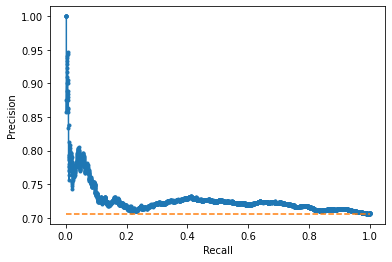

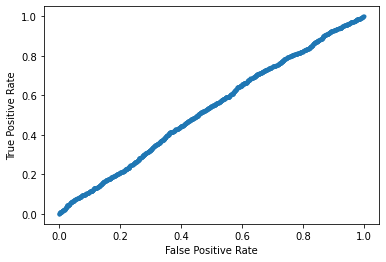

Accuracy: 59.31% Precision: 72.32% Recall: 68.65%
F1: 70.44% MCC: 0.0535
AUPRC: 72.63% AUROC: 52.90%
 accuracy [59.31372549019608]
 precision [72.32486528098538]
 recall [68.65180854950675]
 F1 [70.44048734770384]
 MCC [0.05354828427758791]
 AUPRC [72.6318689317028]
 AUROC [52.89681318952745]
2023-03-21 17:14:10.546197

Training # 1 5
2023-03-21 17:14:10.548910
2023-03-21 17:14:10.548959
Discriminator is GMM
Means [0.024018451612978452, -1.9649463605484332]
Variances [1.36245906 2.32069659]
Priors [0.627736 0.372264]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10819:4394 71.12%
Computed class weights: {0: 1.7311106053709604, 1: 0.7030686754783252}
Valid 1:0 3079:1497 67.29%
FIT
2023-03-21 17:14:24.624070


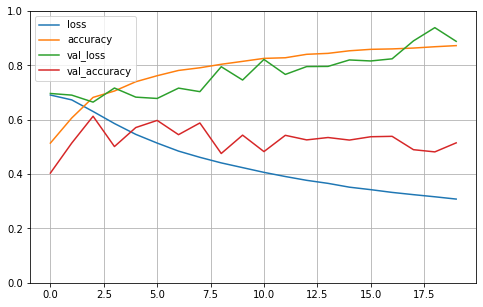


2023-03-21 17:16:48.394193

Testing # 1 5
2023-03-21 17:16:48.394304
2023-03-21 17:16:48.394345
PREDICT
2023-03-21 17:16:49.528812
Test 1:0 3079:1497 67.29%
Predict 1:0 2363:2213 51.64%
Test sizes (4576, 4997) (4576,)
Range of scores: 0.004928765 to 0.9997627
Score threshold 0.5
Confusion matrix
 [[ 745  752]
 [1468 1611]]
Normalized matrix
 [[0.16280594 0.16433566]
 [0.3208042  0.3520542 ]]


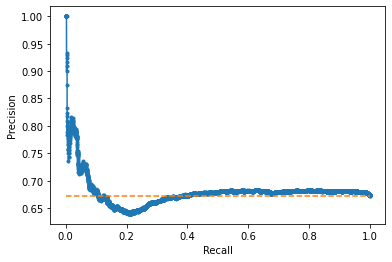

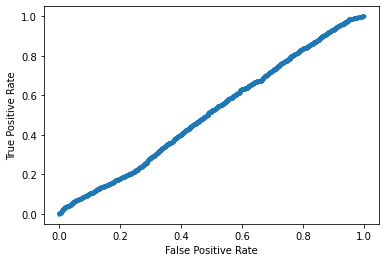

Accuracy: 51.49% Precision: 68.18% Recall: 52.32%
F1: 59.21% MCC: 0.0196
AUPRC: 68.04% AUROC: 51.05%
 accuracy [51.48601398601399]
 precision [68.17604739737621]
 recall [52.322182526794414]
 F1 [59.20617420066152]
 MCC [0.019606633609961042]
 AUPRC [68.04143459405793]
 AUROC [51.04996178347818]
2023-03-21 17:16:51.754848

Training # 2 1
2023-03-21 17:16:51.756005
2023-03-21 17:16:51.756055
Discriminator is GMM
Means [-0.0015806145690699274, -1.8802551862435997]
Variances [1.47007051 2.67238466]
Priors [0.58518419 0.41481581]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10336:5012 67.34%
Computed class weights: {0: 1.531125299281724, 1: 0.742453560371517}
Valid 1:0 3165:1276 71.27%
FIT
2023-03-21 17:17:03.520533


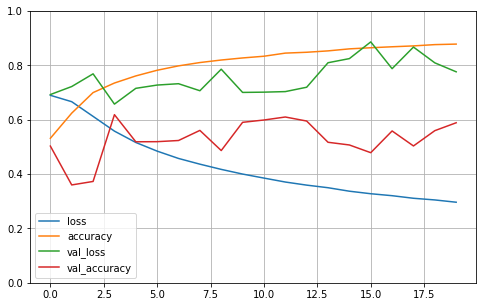


2023-03-21 17:19:27.300545

Testing # 2 1
2023-03-21 17:19:27.300637
2023-03-21 17:19:27.300674
PREDICT
2023-03-21 17:19:28.402411
Test 1:0 3165:1276 71.27%
Predict 1:0 3021:1420 68.03%
Test sizes (4441, 4997) (4441,)
Range of scores: 0.0038193008 to 0.9968934
Score threshold 0.5
Confusion matrix
 [[ 435  841]
 [ 985 2180]]
Normalized matrix
 [[0.09795091 0.18937176]
 [0.22179689 0.49088043]]


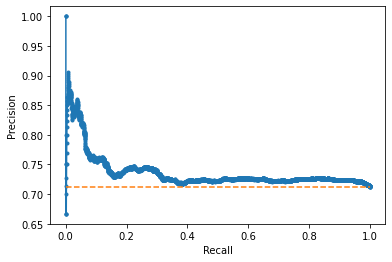

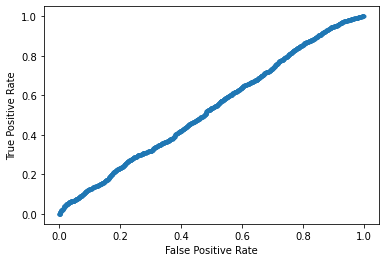

Accuracy: 58.88% Precision: 72.16% Recall: 68.88%
F1: 70.48% MCC: 0.0288
AUPRC: 73.65% AUROC: 53.18%
 accuracy [58.88313442918262]
 precision [72.16153591525985]
 recall [68.8783570300158]
 F1 [70.48173294536049]
 MCC [0.028809902106594443]
 AUPRC [73.65406110760617]
 AUROC [53.17958965368673]
2023-03-21 17:19:30.492365

Training # 2 2
2023-03-21 17:19:30.492593
2023-03-21 17:19:30.492643
Discriminator is GMM
Means [0.06565424729214618, -1.797417641192013]
Variances [1.34439582 2.546908  ]
Priors [0.5758194 0.4241806]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10264:5437 65.37%
Computed class weights: {0: 1.4439028876218503, 1: 0.7648577552611068}
Valid 1:0 2690:1398 65.80%
FIT
2023-03-21 17:19:46.740030


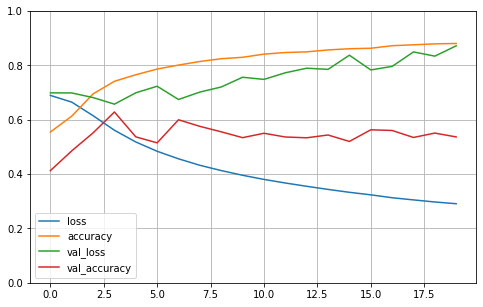


2023-03-21 17:22:10.543365

Testing # 2 2
2023-03-21 17:22:10.543457
2023-03-21 17:22:10.543495
PREDICT
2023-03-21 17:22:11.584250
Test 1:0 2690:1398 65.80%
Predict 1:0 2158:1930 52.79%
Test sizes (4088, 4997) (4088,)
Range of scores: 0.0021806506 to 0.99539125
Score threshold 0.5
Confusion matrix
 [[ 717  681]
 [1213 1477]]
Normalized matrix
 [[0.17539139 0.16658513]
 [0.29672211 0.36130137]]


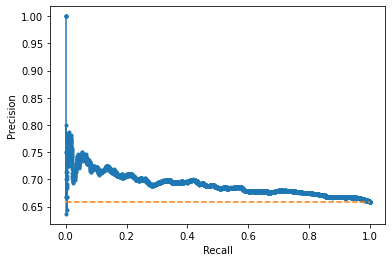

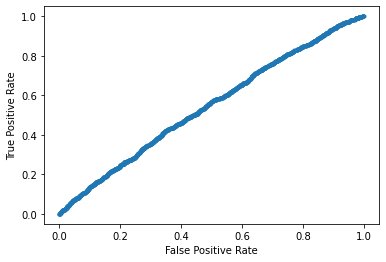

Accuracy: 53.67% Precision: 68.44% Recall: 54.91%
F1: 60.93% MCC: 0.0589
AUPRC: 69.08% AUROC: 54.59%
 accuracy [53.6692759295499]
 precision [68.44300278035217]
 recall [54.90706319702602]
 F1 [60.932343234323426]
 MCC [0.058862648649927324]
 AUPRC [69.07772826393501]
 AUROC [54.58968202051789]
2023-03-21 17:22:13.825571

Training # 2 3
2023-03-21 17:22:13.825722
2023-03-21 17:22:13.825777
Discriminator is GMM
Means [0.22989711327670082, -1.7440377148623039]
Variances [1.29042425 2.02126817]
Priors [0.52688413 0.47311587]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 9032:6979 56.41%
Computed class weights: {0: 1.147084109471271, 1: 0.8863485385296723}
Valid 1:0 2090:1688 55.32%
FIT
2023-03-21 17:22:27.424174


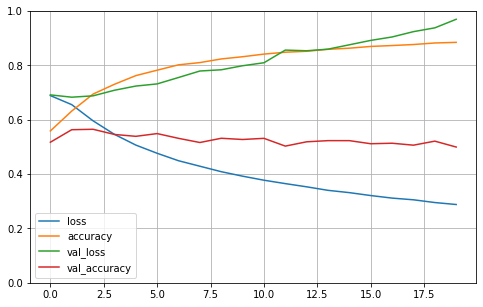


2023-03-21 17:24:17.228290

Testing # 2 3
2023-03-21 17:24:17.229648
2023-03-21 17:24:17.229971
PREDICT
2023-03-21 17:24:18.912609
Test 1:0 2090:1688 55.32%
Predict 1:0 1673:2105 44.28%
Test sizes (3778, 4997) (3778,)
Range of scores: 0.0005846585 to 0.9992291
Score threshold 0.5
Confusion matrix
 [[ 951  737]
 [1154  936]]
Normalized matrix
 [[0.25172049 0.19507676]
 [0.30545262 0.24775013]]


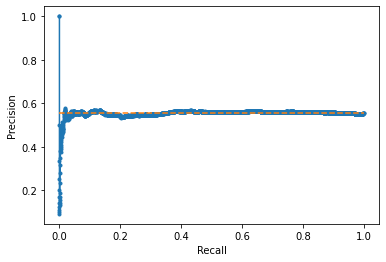

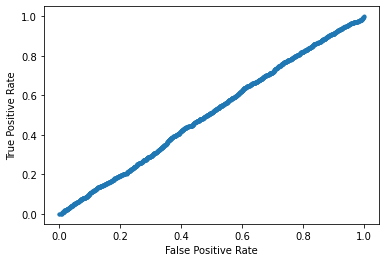

Accuracy: 49.95% Precision: 55.95% Recall: 44.78%
F1: 49.75% MCC: 0.0112
AUPRC: 55.45% AUROC: 50.91%
 accuracy [49.947061937533086]
 precision [55.94739988045427]
 recall [44.78468899521531]
 F1 [49.747541854903005]
 MCC [0.011245489089939532]
 AUPRC [55.453432535039624]
 AUROC [50.90784371527699]
2023-03-21 17:24:20.466062

Training # 2 4
2023-03-21 17:24:20.466940
2023-03-21 17:24:20.466986
Discriminator is GMM
Means [-0.03389314433770613, -1.8457535357861536]
Variances [1.40824418 2.81492043]
Priors [0.60060276 0.39939724]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 11609:4618 71.54%
Computed class weights: {0: 1.756929406669554, 1: 0.6988974071840813}
Valid 1:0 2434:1128 68.33%
FIT
2023-03-21 17:24:33.383965


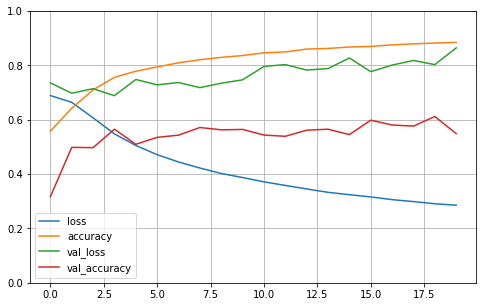


2023-03-21 17:26:57.240665

Testing # 2 4
2023-03-21 17:26:57.240773
2023-03-21 17:26:57.240812
PREDICT
2023-03-21 17:26:58.131305
Test 1:0 2434:1128 68.33%
Predict 1:0 1989:1573 55.84%
Test sizes (3562, 4997) (3562,)
Range of scores: 0.0018676646 to 0.9979948
Score threshold 0.5
Confusion matrix
 [[ 547  581]
 [1026 1408]]
Normalized matrix
 [[0.15356541 0.16311061]
 [0.28804043 0.39528355]]


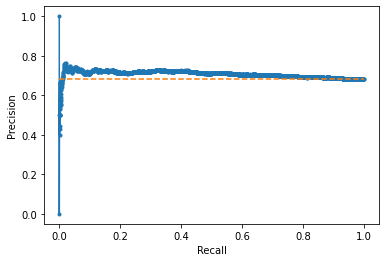

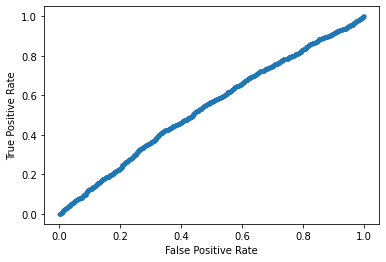

Accuracy: 54.88% Precision: 70.79% Recall: 57.85%
F1: 63.67% MCC: 0.0594
AUPRC: 70.77% AUROC: 54.02%
 accuracy [54.884896125772045]
 precision [70.78934137757668]
 recall [57.84716516023008]
 F1 [63.667194212073255]
 MCC [0.05939191650715885]
 AUPRC [70.76809747759422]
 AUROC [54.015840894654346]
2023-03-21 17:26:59.660332

Training # 2 5
2023-03-21 17:26:59.660479
2023-03-21 17:26:59.660525
Discriminator is GMM
Means [-1.8356883998549485, -0.07278927654138478]
Variances [2.66546851 1.49474544]
Priors [0.42783233 0.57216767]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10665:5204 67.21%
Computed class weights: {0: 1.5246925441967718, 1: 0.7439756211908111}
Valid 1:0 2838:1082 72.40%
FIT
2023-03-21 17:27:13.641546


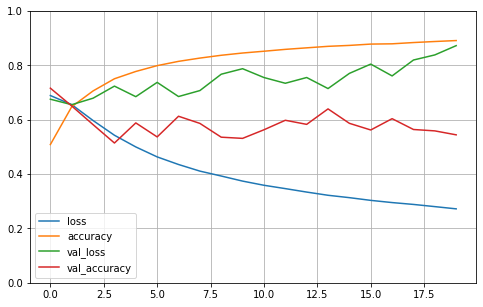


2023-03-21 17:29:37.429605

Testing # 2 5
2023-03-21 17:29:37.430026
2023-03-21 17:29:37.430059
PREDICT
2023-03-21 17:29:38.613683
Test 1:0 2838:1082 72.40%
Predict 1:0 2130:1790 54.34%
Test sizes (3920, 4997) (3920,)
Range of scores: 0.0108078085 to 0.99735475
Score threshold 0.5
Confusion matrix
 [[ 543  539]
 [1247 1591]]
Normalized matrix
 [[0.13852041 0.1375    ]
 [0.31811224 0.40586735]]


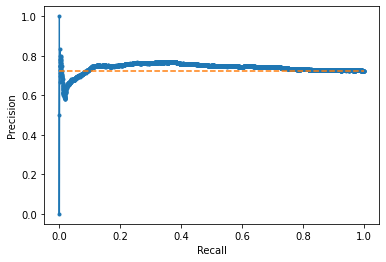

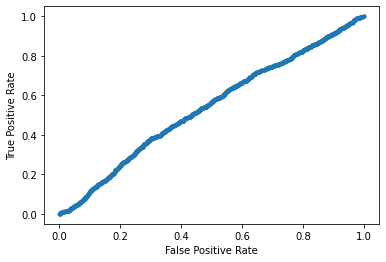

Accuracy: 54.44% Precision: 74.69% Recall: 56.06%
F1: 64.05% MCC: 0.0560
AUPRC: 74.00% AUROC: 53.97%
 accuracy [54.43877551020408]
 precision [74.69483568075117]
 recall [56.060606060606055]
 F1 [64.04991948470209]
 MCC [0.05604890999724137]
 AUPRC [74.00341607869481]
 AUROC [53.973861470744936]
2023-03-21 17:29:40.817832


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 54.27% std 2.98
 precision mean 68.26% std 5.31
 recall mean 57.48% std 7.45
 F1 mean 62.26% std 5.93
 MCC mean 0.04% std 0.02
 AUPRC mean 68.43% std 5.72
 AUROC mean 52.85% std 1.33
 accuracy [[53.88739946380697], [51.81749811982953], [54.39469320066335], [59.31372549019608], [51.48601398601399], [58.88313442918262], [53.6692759295499], [49.947061937533086], [54.884896125772045], [54.43877551020408]]
 precision [[65.4054054054054], [69.85901798736023], [64.75113122171946], [72.32486528098538], [68.17604739737621], [72.16153591525985], [68.44300278035217], [55.94739988045427], [70.78934137757668], [74.69483568075117]]
 recall [[56.71069450362164], [52.46440306681271], [62.163336229365775], [68.65180854950675], [52.322182526794414], [68.8783570300158], [54.90706319702602], [44.78468899521531], [57.84716516023008], [56.060606060606055]]
 F1 [[60.748516659059796], [59.924937447873226], [63.430851063829785], [70.44048734770384], [59.20617420066152], [70.48173294536049], [60.